In [17]:
import pandas as pd
import tensorflow as tf
import seaborn

from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

from sent_functions import get_sent_flair as s_flair
from sent_functions import get_sent_nltk as s_nltk
from sent_functions import get_sent_textblob as s_textblob
from sent_functions import tokenize

In [18]:
SEED = 0

In [19]:
#tqdm progress bar for pandas methods
tqdm.pandas()

In [20]:
# Read in data
df = pd.read_csv('data_test.csv', sep='\t')

In [21]:
# Sampling (optional)
#df = df.sample(n=10000, random_state = SEED)

In [22]:
df.head()

,sent,text,data_len,token_lens
0,0,hes not allowed to be an asshole on date night,10,13
1,0,us linux users are still waiting too although ...,18,20
2,0,i applaud your singleminded zeal in the face o...,22,30
3,1,watching the zoo with a hot milo oh and in fro...,14,17
4,0,yeh i seem to have lost that lovin feeling tow...,11,15


### Model Comparison

We start by applying the out-of-the-box sentiment analysis functions (s_flair, s_nltk, s_textblob) on our test data.

In [23]:
df['flair_sent'] = df['text'].progress_apply(s_flair)
df['nltk_sent'] = df['text'].progress_apply(s_nltk)
df['textblob_sent'] = df['text'].progress_apply(s_textblob)

100%|██████████| 231055/231055 [00:35<00:00, 6554.91it/s]


Initializing DistilBert model

In [24]:
model = TFDistilBertForSequenceClassification.from_pretrained('trained_distilbert_model')

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Some layers from the model checkpoint at trained_distilbert_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at trained_distilbert_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [26]:
MAX_LEN = 128

In [27]:
test_input_ids, test_attention_masks = tokenize(df.text.values, max_len=MAX_LEN)

100%|██████████| 231055/231055 [01:07<00:00, 3436.71it/s]


In [28]:
y = df['sent']

In [29]:
results = model.evaluate([test_input_ids,test_attention_masks], y, batch_size=128)

1806/1806 [==============================] - 395s 217ms/step - loss: 0.2340 - accuracy: 0.9077


In [33]:
plot_keys = ['flair', 'nltk', 'textblob', 'DistilBert']
plot_data = [accuracy_score(df['sent'], df['flair_sent']),
             accuracy_score(df['sent'], df['nltk_sent']),
             accuracy_score(df['sent'], df['textblob_sent']),
             results[1]
             ]

df_acc = pd.DataFrame({'model_name': plot_keys, 'accuracy': plot_data})

In [34]:
df_acc.head()

,model_name,accuracy
0,flair,0.700418
1,nltk,0.653788
2,textblob,0.626007
3,DistilBert,0.907671


(0.2, 1.0)

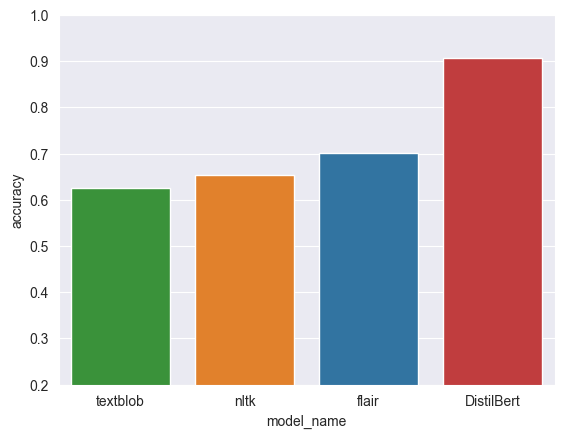

In [35]:
seaborn.set_style("darkgrid")

acc_plot = seaborn.barplot(
    data=df_acc,
    x='model_name',
    y='accuracy',
    order=df_acc.sort_values('accuracy').model_name,
    hue='model_name'
)

acc_plot.set_ylim(0.2, 1)

In [37]:
# save the plot as PNG file
acc_plot.figure.savefig("seaborn_plot.png")